# Explore different embedding spaces of Axiom data

Look at PCA and UMAP of Axiom data with different features. Explore how correlated the Dino and CP CNN features are.

In [40]:
# Imports

import polars as pl
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

In [121]:
# Paths
prof_path = "/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet"

In [122]:
data = pl.read_parquet(prof_path)
metadata_cols = [col for col in data.columns if "Metadata" in col]

<Axes: xlabel='Metadata_Count_Cells', ylabel='Count'>

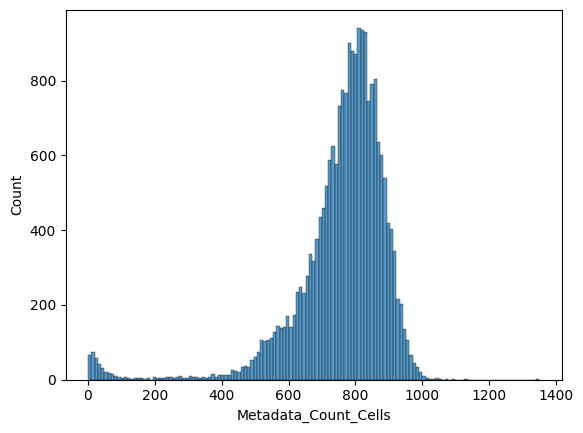

In [95]:
sns.histplot(data.to_pandas(), x="Metadata_Count_Cells")

In [123]:
data = data.filter(
    ~pl.col("Metadata_Plate").is_in(["plate_41002698", "plate_41002695", "plate_41002696"])
).filter(
    pl.col("Metadata_Count_Cells") > 0
).to_pandas()

In [124]:
data.sort_values(["Metadata_Plate", "Metadata_Well"], inplace=True)
data.index = [f"{row['Metadata_Plate']}__{row['Metadata_Well']}" for _, row in data.iterrows()]
data = data.loc[~data.index.duplicated(keep='first')]

In [125]:
metadata = data[metadata_cols]
adata = anndata.AnnData(X=data.drop(metadata_cols, axis=1))
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)


In [126]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 4432 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.


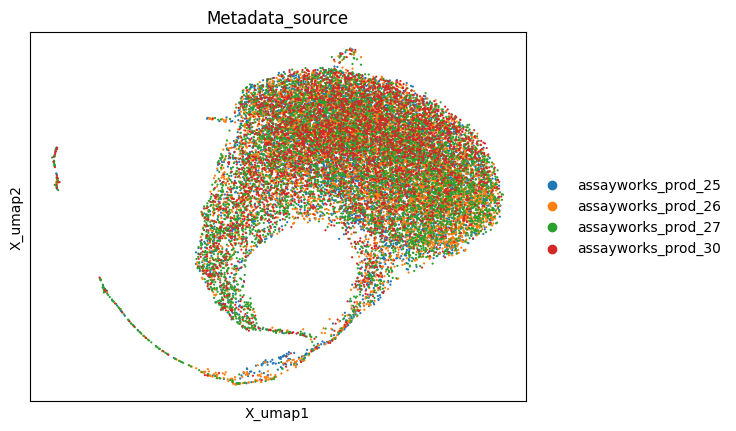

In [100]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_source",
    s=10
)

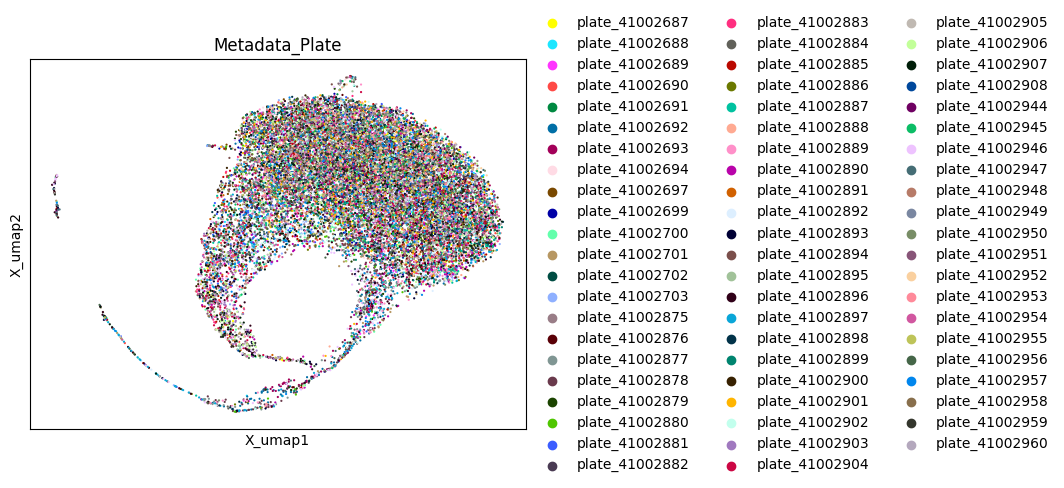

In [101]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_Plate",
    s=10
)

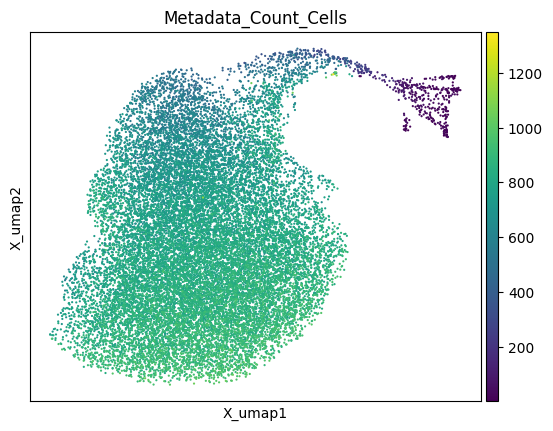

In [127]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_Count_Cells",
    s=10
)

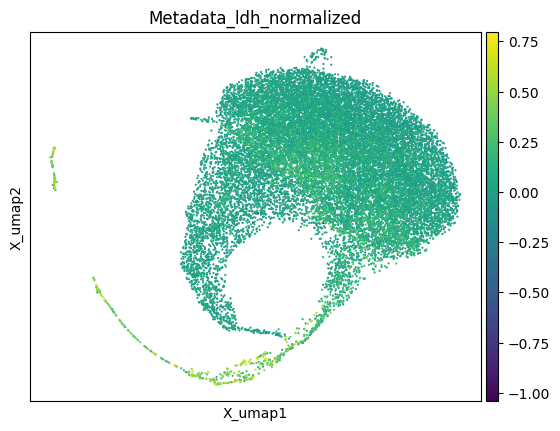

In [103]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_ldh_normalized",
    s=10
)

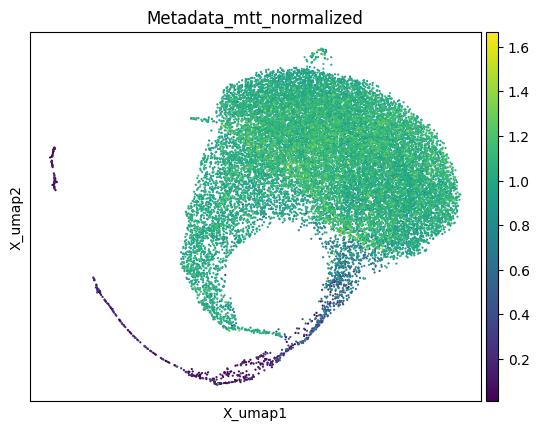

In [104]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_mtt_normalized",
    s=10
)

<Axes: title={'center': 'Metadata_Compound'}, xlabel='X_umap1', ylabel='X_umap2'>

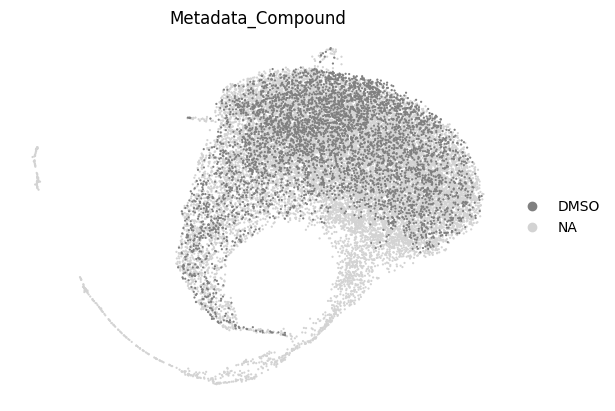

In [105]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_Compound",
    groups=["DMSO"],
    s=10,
    show=False,
    sort_order=True,
    frameon=False,
)

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


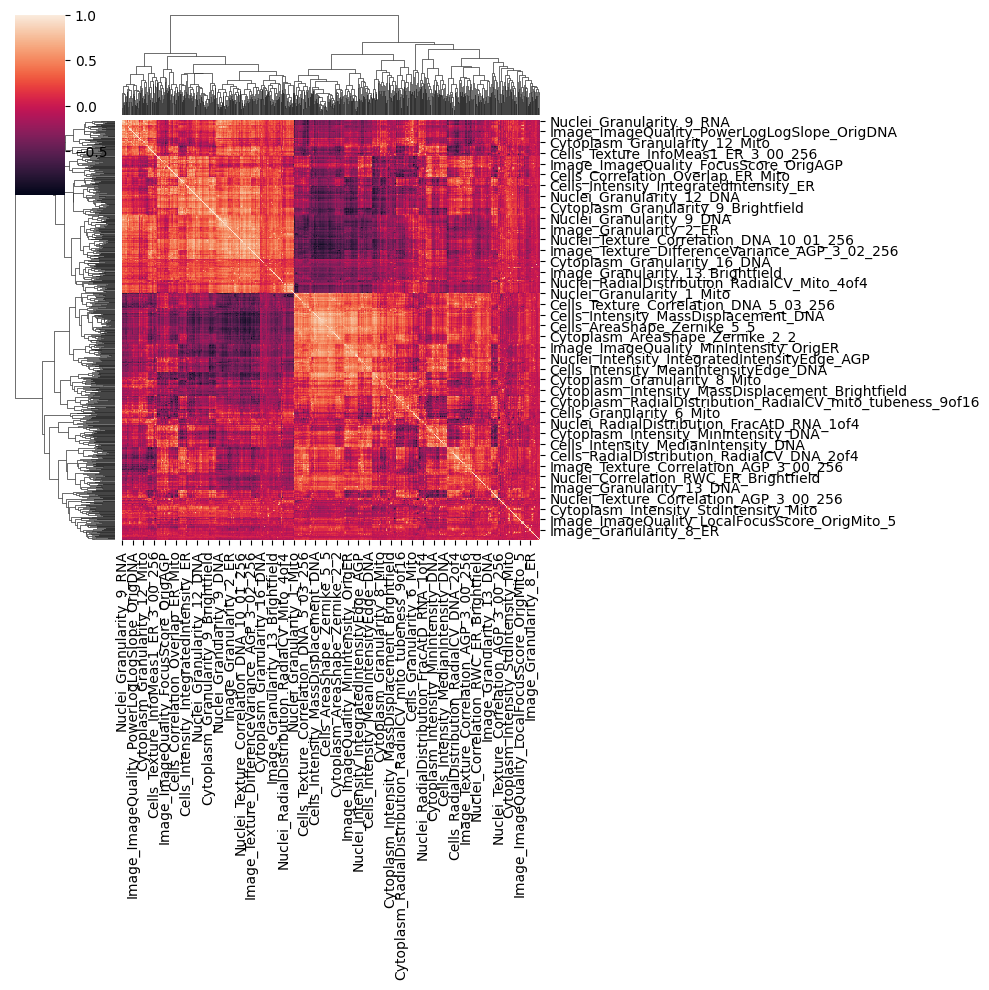

In [106]:
data_matrix = pl.DataFrame(adata.X.T).to_numpy()
correlation_matrix = np.corrcoef(data_matrix)
sns.clustermap(pd.DataFrame(correlation_matrix, index=adata.var_names, columns=adata.var_names), figsize=(10, 10))

In [75]:
metadata = metadata[metadata["Metadata_ldh_normalized"] > -0.5]

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_85033/801687546.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/mizani/bounds.py:243: RuntimeWarning: invalid value encountered in cast


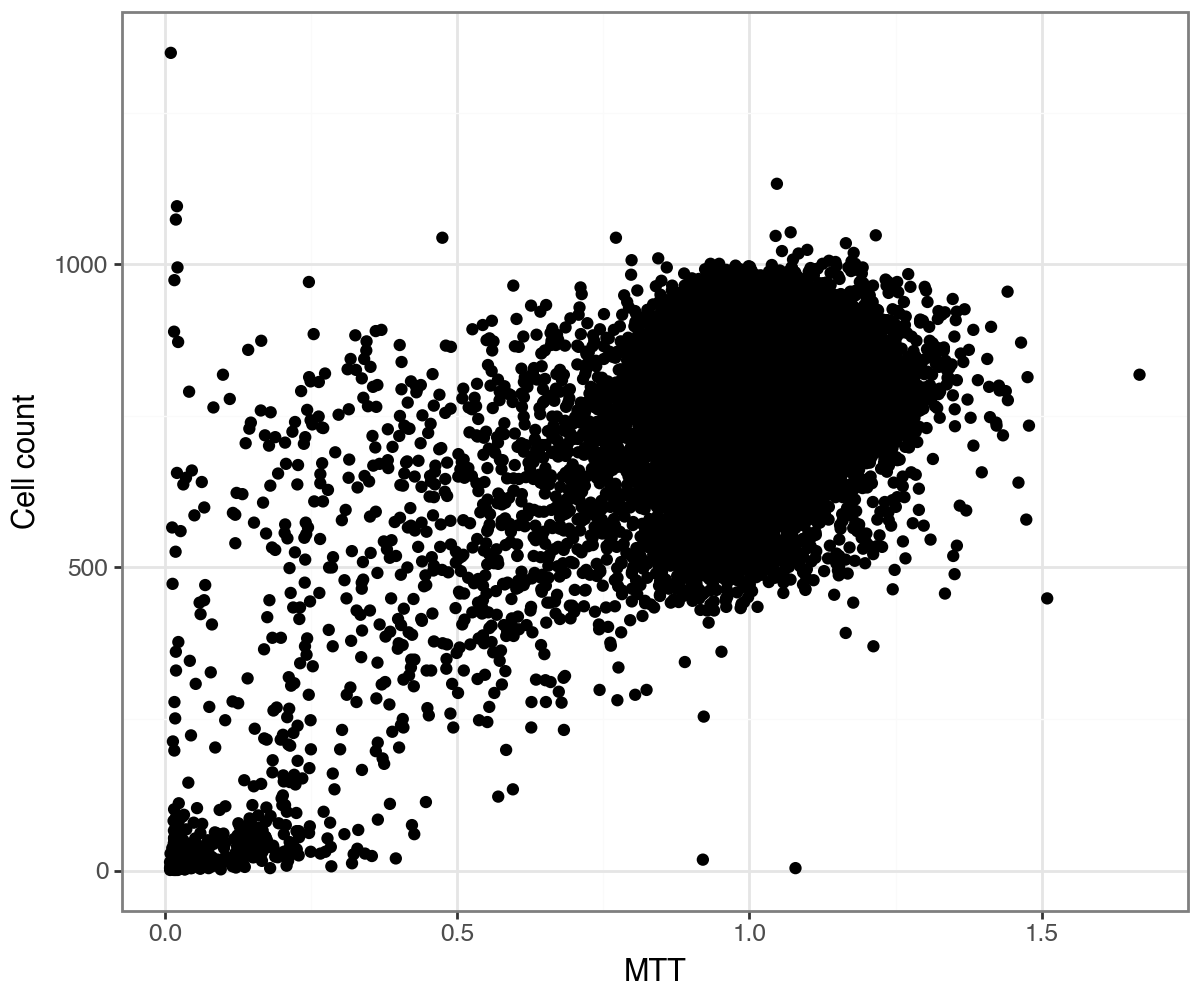

In [133]:
from plotnine import ggplot, aes, geom_point, labs, theme_bw

import plotnine as plotnine

plotnine.options.figure_size = (6, 5)

p = (ggplot(metadata, aes(y="Metadata_Count_Cells", x="Metadata_mtt_normalized"))
    + geom_point()
    + labs(
        x='MTT',
        y='Cell count'
    )
    + theme_bw())

print(p)

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_85033/1115797534.py:12: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/mizani/bounds.py:243: RuntimeWarning: invalid value encountered in cast


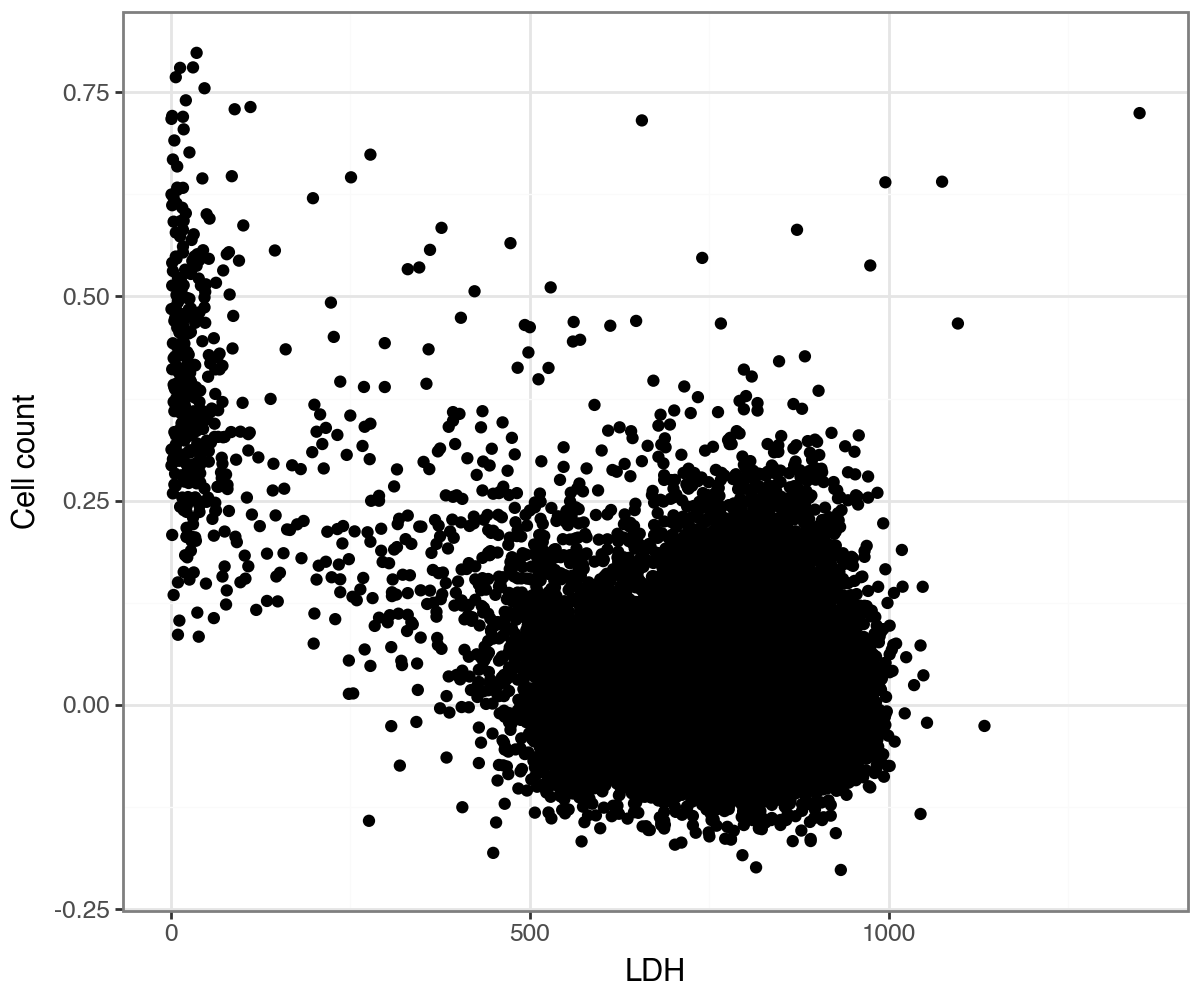

In [136]:
plotnine.options.figure_size = (6, 5)
metadata = metadata[metadata["Metadata_ldh_normalized"] > -0.5]

p = (ggplot(metadata, aes(x="Metadata_Count_Cells", y="Metadata_ldh_normalized"))
    + geom_point()
    + labs(
        x='LDH',
        y='Cell count'
    )
    + theme_bw())

print(p)

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_85033/478836611.py:5: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


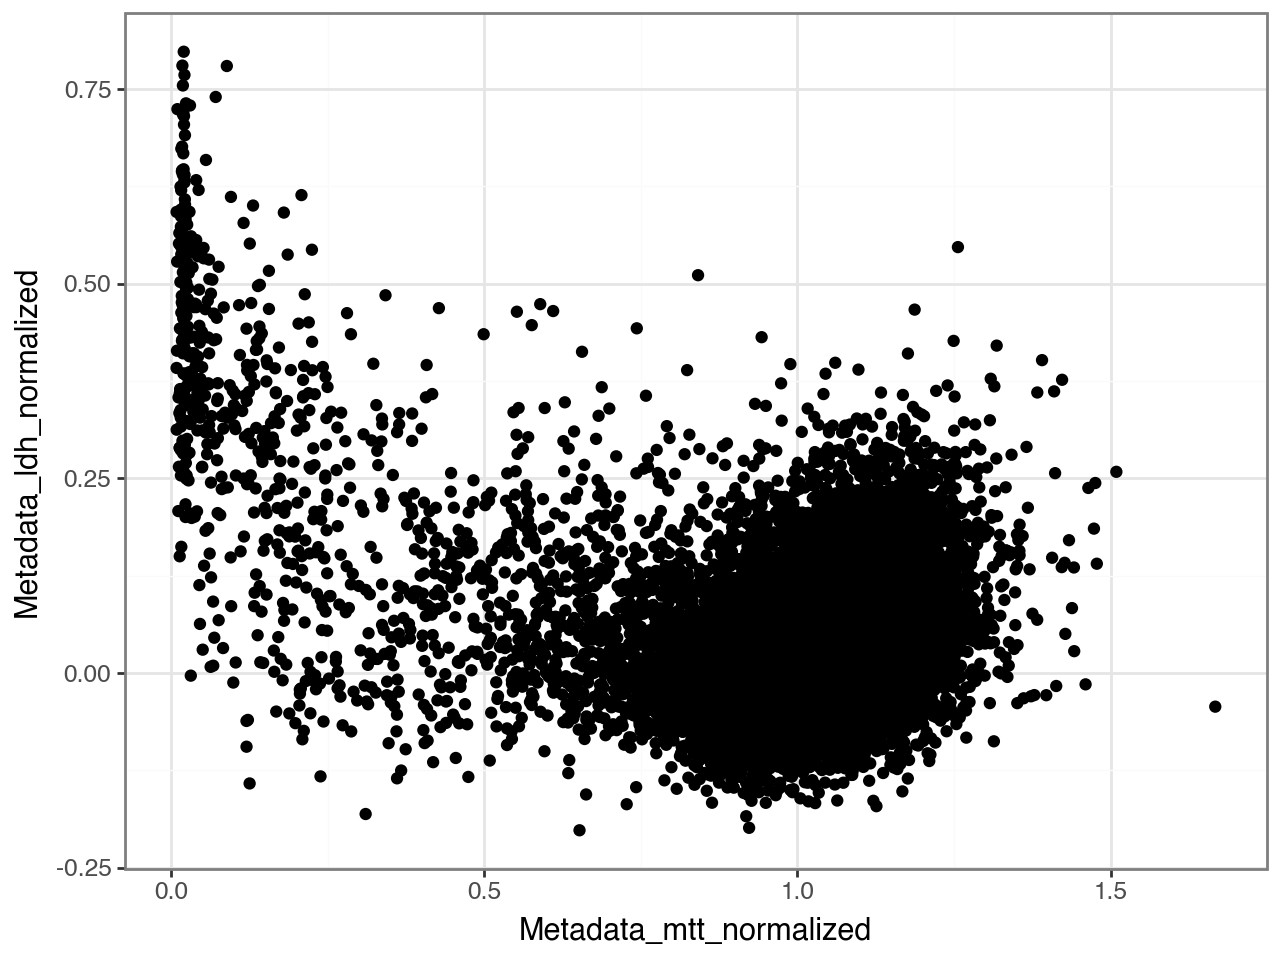

In [78]:
p = (ggplot(metadata, aes(x="Metadata_mtt_normalized", y="Metadata_ldh_normalized"))
    + geom_point()
    + theme_bw())

print(p)

In [108]:
# How many compounds had cell count decrease

cc = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/ccpods.parquet")

cc.select("all.pass").sum()

all.pass
u32
220


In [114]:
cp = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/pods.parquet")
len(cp.select("Metadata_Compound").to_series().unique().to_list())

580

In [115]:
dino = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/pods.parquet")
len(dino.select("Metadata_Compound").to_series().unique().to_list())

620

In [116]:
cpcnn = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/curves/pods.parquet")
len(cpcnn.select("Metadata_Compound").to_series().unique().to_list())

349

In [118]:
# cp
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/curves/bmds.parquet")
bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true")
).select("Metadata_Compound").to_series().unique().shape

(244,)

In [119]:
# dino
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/curves/bmds.parquet")
bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true")
).select("Metadata_Compound").to_series().unique().shape

(545,)

In [120]:
# cpcnn
bmds = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/curves/bmds.parquet")
bmds.filter(
    (pl.col("gene.id") == "gmd") & (pl.col("all.pass") == "true")
).select("Metadata_Compound").to_series().unique().shape

(540,)